## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**OCO-2 MIP Top-down CO2 Budgets**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/oco2-mip-co2budget-yeargrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1° x 1°
- **Temporal extent**: 2015 – 2020
- **Temporal resolution**: Annual
- **Unit**: Grams of carbon dioxide per square meter per year
- **Utility**: Climate Research

For more, visit the [OCO-2 MIP Top-down CO2 Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.  

## About the Data

The Committee on Earth Observation Satellites (CEOS) Atmospheric Composition - Virtual Constellation (AC-VC) Greenhouse Gas (GHG) team has generated the CEOS CO₂ Budgets dataset, which provides annual top-down carbon dioxide (CO2) emissions and removals from 2015 - 2020 gridded globally at 1° resolution, and as national totals. Data is provided in units of grams of carbon dioxide per square meter per year (g CO2/m2/yr). Only a subset of the full dataset is displayed in the GHG Center explore view. 

For more information regarding this dataset, please visit the [OCO-2 MIP Top-Down CO₂ Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 MIP Top-Down CO₂ Budgets data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import pandas as pd
import matplotlib.pyplot as plt

/Users/rrimal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for CEOS National Top-Down CO₂ Budgets dataset 
collection_name = "oco2-mip-co2budget-yeargrid-v1"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

{'id': 'oco2-mip-co2budget-yeargrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'}],
 'title': 'OCO-2 MIP Top-down CO₂ Budgets v1',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2015-01-01T00:00:00+00:00',
     '2020-01-01T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'renders': {'ff': {'assets': ['ff'],
   'nodata': 0,
   'rescale': [[0, 450]],
   'colormap_name': 'purd'},
  'crop': {'assets': ['crop'],
   'nodata': 0,
   'rescale': [[-100, 100]],
   

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to December 2020. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [4]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
        
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]

    # Return the information about the total number of granules found associated with the collection
    return count

In [5]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 6 items


In [6]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

{'id': 'oco2-mip-co2budget-yeargrid-v1-2020',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020/map?assets=lnlgis-nbe&nodata=0&rescale=-1200%2C1200&colormap_name=coolwarm',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': 

## Visual Comparison Across Time Periods

In [7]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"]: item for item in items} 

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the OCO-2 MIP Top-Down CO₂ Budgets collection, the parameter of interest is “ff”
asset_name = "ff" #fossil fuel

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [8]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

# Hardcoding the min and max values to match the scale in the GHG Center dashboard
rescale_values = {"max": 450, "min": 0}

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. We will do this twice, once for 2020 and again for 2019, so that we can visualize each event independently.

In [9]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "purd"

# Make a GET request to retrieve information for the 2020 tile which is the 1st item in the collection
# To retrieve the first item in the collection we use "0" in the "(items.keys())[0]" statement

# 2020
co2_flux_1 = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/collections/{items[list(items.keys())[0]]['collection']}/items/{items[list(items.keys())[0]]['id']}/tilejson.json?"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
co2_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ff&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0%2C450'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [10]:
# Make a GET request to retrieve information for the 2019 tile which is the 2st item in the collection
# To retrieve the second item in the collection we use "1" in the "(items.keys())[1]" statement

# 2019
co2_flux_2 = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/collections/{items[list(items.keys())[1]]['collection']}/items/{items[list(items.keys())[1]]['id']}/tilejson.json?"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
co2_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2019/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ff&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0%2C450'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Map Out Selected Tiles

In [11]:
# For this study we are going to compare the CO2 budget in 2020 and 2019 along the coast of California
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# Define the first map layer (2020)
map_layer_2020 = TileLayer(
    tiles=co2_flux_1["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2020.add_to(map_.m1)

# Define the second map layer (2019)
map_layer_2019 = TileLayer(
    tiles=co2_flux_2["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2019.add_to(map_.m2)

# Visualize the Dual Map
map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [12]:
# Create a polygon for the area of interest (aoi)
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-95, 29], # South-east bounding coordinate
                [-95, 33], # North-east bounding coordinate
                [-104,33], # North-west bounding coordinate
                [-104,29], # South-west bounding coordinate
                [-95, 29]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [13]:
# Create a new map to display the generated polygon
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=6,
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

In [14]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 6 items


In [15]:
# Examine the first item in the collection
items[0]

{'id': 'oco2-mip-co2budget-yeargrid-v1-2020',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020/map?assets=lnlgis-nbe&nodata=0&rescale=-1200%2C1200&colormap_name=coolwarm',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': 

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [16]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

In [17]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2020-01-01T00:00:00+00:00


With the function above we can generate the statistics for the AOI.

In [18]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'b1': {'min': 0.03978176414966583, 'max': 7348.5, 'mean': 710.6574534496499, 'count': 36.0, 'sum': 25583.668324187398, 'std': 1398.048920955156, 'median': 88.17879486083984, 'majority': 0.03978176414966583, 'minority': 0.03978176414966583, 'unique': 36.0, 'histogram': [[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.03978176414966583, 734.8858035877347, 1469.7318254113197, 2204.5778472349048, 2939.42386905849, 3674.269890882075, 4409.11591270566, 5143.961934529245, 5878.80795635283, 6613.653978176415, 7348.5]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 36.0, 'percentile_2': 0.03978176414966583, 'percentile_98': 7348.5}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': 

In [19]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.03978176414966583,
   'max': 7348.5,
   'mean': 710.6574534496499,
   'count': 36.0,
   'sum': 25583.668324187398,
   'std': 1398.048920955156,
   'median': 88.17879486083984,
   'majority': 0.03978176414966583,
   'minority': 0.03978176414966583,
   'unique': 36.0,
   'histogram': [[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.03978176414966583,
     734.8858035877347,
     1469.7318254113197,
     2204.5778472349048,
     2939.42386905849,
     3674.269890882075,
     4409.11591270566,
     5143.961934529245,
     5878.80795635283,
     6613.653978176415,
     7348.5]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 36.0,
   'percentile_2': 0.03978176414966583,
   'percentile_98': 7348.5}},
 'datetime': '2020-01-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [20]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.039782,7348.500000,710.657453,36.0,25583.668324,1398.048921,88.178795,0.039782,0.039782,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.039782,7348.500000,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,0.091393,8174.177246,795.299751,36.0,28630.791028,1557.578314,102.494843,0.091393,0.091393,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.091393,8174.177246,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,0.091512,8392.841797,816.330697,36.0,29387.905075,1599.111075,105.021027,0.091512,0.091512,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.091512,8392.841797,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,0.091022,8138.964844,791.945597,36.0,28510.041476,1550.823779,102.053978,0.091022,0.091022,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.091022,8138.964844,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,0.088426,8243.259766,801.738824,36.0,28862.597653,1570.489286,103.013275,0.088426,0.088426,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.088426,8243.259766,2016-01-01 00:00:00+00:00


## Time-Series Analysis
We can now explore the fossil fuel emission time series (January 2015 -December 2020) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

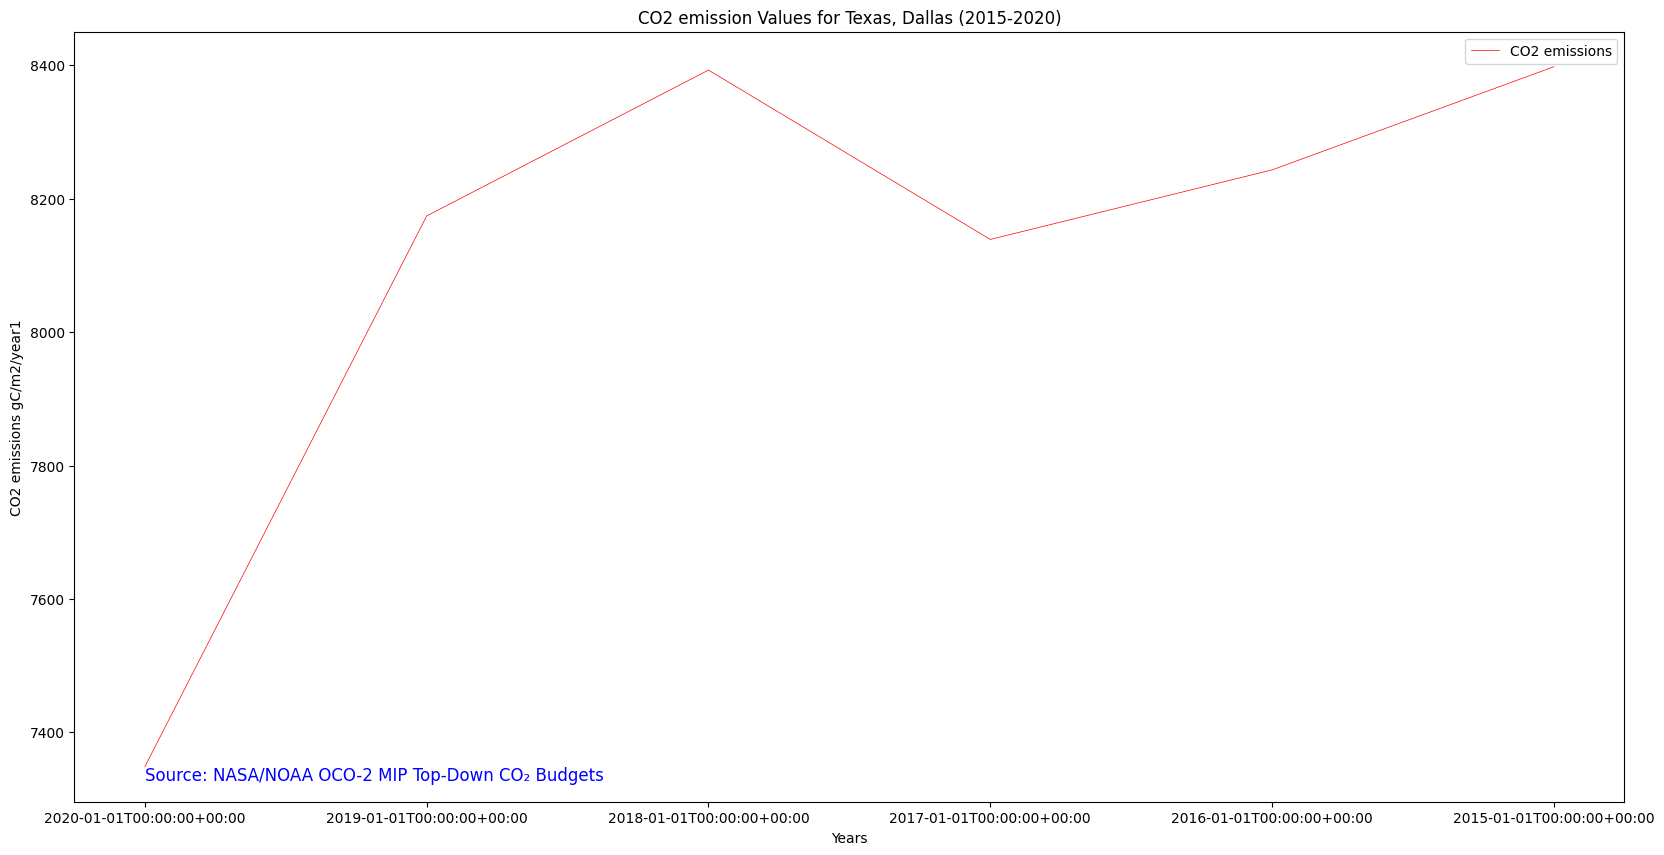

In [21]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂ emission
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO2 emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("CO2 emissions gC/m2/year1")

# Insert title for the plot
plt.title("CO2 emission Values for Texas, Dallas (2015-2020)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text 
    df["max"].min(),                  # Y-coordinate of the text 


    # Text to be displayed
    "Source: NASA/NOAA OCO-2 MIP Top-Down CO₂ Budgets",                  
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 MIP Top-Down CO₂ Budgets.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Visualizing CO₂ Emissions for two distinctive months/years
5.  Generate zonal statistics for a specified region
6.  Generate a time-series graph


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).